# Clustering for reducing Store_ID cardinality

In [174]:
import pandas as pd
import numpy as np
import duckdb as db
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import fastcluster
import umap

In [185]:
orig=pd.read_parquet("../../data/processed/train_enhanced.parquet")
orig.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,Day_of_Week_Name,Day,Day_of_Week,Month_Name,Month,Year,Quarter,Week,Week_of_Month,Is_Weekend
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,9,7011.84,Monday,1,0,January,1,2018,1,1,1,0
1,T1000002,253,S4,L2,R1,2018-01-01,1,1,60,51789.12,Monday,1,0,January,1,2018,1,1,1,0
2,T1000003,252,S3,L2,R1,2018-01-01,1,1,42,36868.20,Monday,1,0,January,1,2018,1,1,1,0
3,T1000004,251,S2,L3,R1,2018-01-01,1,1,23,19715.16,Monday,1,0,January,1,2018,1,1,1,0
4,T1000005,250,S2,L3,R4,2018-01-01,1,1,62,45614.52,Monday,1,0,January,1,2018,1,1,1,0


In [186]:
orig.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', 'Orders', 'Sales', 'Day_of_Week_Name', 'Day',
       'Day_of_Week', 'Month_Name', 'Month', 'Year', 'Quarter', 'Week',
       'Week_of_Month', 'Is_Weekend'],
      dtype='object')

In [187]:
cols = ['Store_id', 'Store_Type', 'Location_Type', 'Region_Code',  'Orders', 'Sales', 'Discount']
df = orig[cols]
df.head()

,Store_id,Store_Type,Location_Type,Region_Code,Orders,Sales,Discount
0,1,S1,L3,R1,9,7011.84,1
1,253,S4,L2,R1,60,51789.12,1
2,252,S3,L2,R1,42,36868.20,1
3,251,S2,L3,R1,23,19715.16,1
4,250,S2,L3,R4,62,45614.52,1


In [188]:
df.describe()

,Store_id,Orders,Sales,Discount
count,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,68.205692,42784.327982,0.447536
std,105.366308,30.467415,18456.708302,0.497241
min,1.000000,0.000000,0.000000,0.000000
25%,92.000000,48.000000,30426.000000,0.000000
50%,183.000000,63.000000,39678.000000,0.000000
75%,274.000000,82.000000,51909.000000,1.000000
max,365.000000,371.000000,247215.000000,1.000000


**Sales Ratio No-Discount vs Discount**

In [189]:
discount_sales_ratio= db.sql("""
select Store_Id, 
       avg(case when Discount=1 then Sales else null end) / avg(case when Discount=0 then Sales else null end) as Discount_Sales_Ratio
from df
group by Store_Id
order by Store_Id
""").pl()
discount_sales_ratio.head()

Store_id,Discount_Sales_Ratio
i64,f64
1,1.469801
2,1.466662
3,1.210015
4,1.368282
5,1.264166


**Sales Ratio No-Weekend vs Weekend**

In [190]:
orig["Is_Weekend"].value_counts()

Is_Weekend
0    135050
1     53290
Name: count, dtype: int64

In [191]:
db.sql("""
select Store_Id, 
       avg(case when Is_Weekend=1 then Sales else null end) / avg(case when Is_Weekend=0 then Sales else null end) as Weekend_Sales_Ratio
from orig
group by Store_Id
order by Weekend_Sales_Ratio
""")

┌──────────┬─────────────────────┐
│ Store_id │ Weekend_Sales_Ratio │
│  int64   │       double        │
├──────────┼─────────────────────┤
│      181 │  1.1110012170483543 │
│      154 │  1.1216480606027304 │
│      156 │  1.1220788670739696 │
│      124 │    1.12357660229095 │
│      263 │  1.1244642918676453 │
│      198 │  1.1249953508526112 │
│      300 │  1.1252056467191314 │
│      338 │  1.1268278733949977 │
│      226 │  1.1287888552507204 │
│       60 │  1.1335822949143795 │
│        · │           ·         │
│        · │           ·         │
│        · │           ·         │
│      135 │  1.2030860692499517 │
│       79 │   1.203595605924359 │
│      108 │  1.2038167903085764 │
│      315 │  1.2040246819860494 │
│       90 │   1.205663113457366 │
│      153 │  1.2088867755384258 │
│      260 │   1.212206070618054 │
│      277 │  1.2134194443280182 │
│       39 │   1.218820757990237 │
│      289 │  1.2212385778335701 │
├──────────┴─────────────────────┤
│ 365 rows (20 shown

**Average Monthly Growth Rate**

In [192]:
avg_monthly_growth_rate=db.sql("""
with Monthly_sales_table as (
    select Store_id,Month, Year, sum(Sales) as Monthly_Sales from orig group by Store_id, Month, Year
),
growth_table as (
    select 
        Store_id, Month, Year,
        Monthly_Sales,
        lag(Monthly_Sales, 1) over (partition by Store_id order by Year, Month) as Last_Month_Sales
    from Monthly_sales_table
),
final_table as (
    select 
        Store_id, Month, Year,
        Monthly_Sales,
        Last_Month_Sales,
        (Monthly_Sales - Last_Month_Sales)/Last_Month_Sales as Sales_Growth
    from growth_table
        order by Store_id, Year, Month
)
select Store_id, avg(Sales_Growth) as Avg_Sales_Growth from final_table group by Store_id order by 2 desc
       """).pl()
avg_monthly_growth_rate.head()

Store_id,Avg_Sales_Growth
i64,f64
3,0.064006
82,0.05916
253,0.058027
356,0.049355
352,0.048702


In [193]:
agg=db.sql("""
select Store_id, Store_Type, Location_Type, Region_Code
       , sum(Sales) as total_sales
        , stddev(Sales) as std_sales
       , avg(Sales) as avg_sales
       , sum(Orders) as total_orders
        , avg(Orders) as avg_orders
from df
group by Store_id, Store_Type, Location_Type, Region_Code
""").pl()

In [194]:
agg = agg.join(discount_sales_ratio, on='Store_id', how='left')
agg = agg.join(avg_monthly_growth_rate, on='Store_id', how='left')

In [195]:
agg.describe()

statistic,Store_id,Store_Type,Location_Type,Region_Code,total_sales,std_sales,avg_sales,total_orders,avg_orders,Discount_Sales_Ratio,Avg_Sales_Growth
str,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64
"""count""",365.0,"""365""","""365""","""365""",365.0,365.0,365.0,365.0,365.0,365.0,365.0
"""null_count""",0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",183.0,null,null,null,2.2077e7,12437.186858,42784.327982,35194.136986,68.205692,1.335166,0.018421
"""std""",105.510663,null,null,null,6.7347e6,4057.222688,13051.704523,12553.955963,24.329372,0.152958,0.012913
"""min""",1.0,"""S1""","""L1""","""R1""",9.6458e6,5211.607689,18693.455233,13848.0,26.837209,0.99373,-0.025882
"""25%""",92.0,null,null,null,1.7468e7,9576.740342,33852.618663,26671.0,51.687984,1.232448,0.008204
"""50%""",183.0,null,null,null,2.0970e7,11512.492807,40640.009302,33098.0,64.143411,1.323312,0.018133
"""75%""",274.0,null,null,null,2.6090e7,14665.730475,50561.13436,39967.0,77.455426,1.416017,0.026508
"""max""",365.0,"""S4""","""L5""","""R4""",5.2560e7,31750.856434,101860.959593,94381.0,182.908915,2.04392,0.064006


In [196]:
agg["total_sales"].quantile(0.25), agg["total_sales"].quantile(0.75)

(17467951.229999997, 26089545.330000002)

In [197]:
# agg = agg.with_columns(
#     pl.when(agg["total_sales"] <  agg["total_sales"].quantile(0.25) ).then(1)
#     .when(agg["total_sales"] >  agg["total_sales"].quantile(0.75) ).then(3)
#     .otherwise(2).alias("sales_quantile")
# )
# agg = agg.with_columns(
#     pl.when(agg["total_orders"] <  agg["total_orders"].quantile(0.25) ).then(1)
#     .when(agg["total_orders"] >  agg["total_orders"].quantile(0.75) ).then(3)
#     .otherwise(2).alias("orders_quantile")
# )

agg = agg.with_columns(
    average_sales_per_order=agg["total_sales"]/agg["total_orders"],
    
)
agg.head()

Store_id,Store_Type,Location_Type,Region_Code,total_sales,std_sales,avg_sales,total_orders,avg_orders,Discount_Sales_Ratio,Avg_Sales_Growth,average_sales_per_order
i64,str,str,str,f64,f64,f64,"decimal[38,0]",f64,f64,f64,f64
267,"""S4""","""L2""","""R1""",2.6711e7,15232.585843,51765.086802,41825,81.056202,1.226717,0.036263,638.632033
82,"""S4""","""L2""","""R1""",3.2487e7,18733.878582,62960.149942,58482,113.337209,1.170018,0.05916,555.511736
357,"""S4""","""L1""","""R1""",2.8144e7,16236.630083,54542.096919,49830,96.569767,1.21329,0.003493,564.794742
201,"""S4""","""L1""","""R1""",2.8052e7,14584.098817,54363.798023,53068,102.844961,1.159089,0.04247,528.599529
295,"""S1""","""L1""","""R1""",1.8989e7,10058.665397,36801.064477,26870,52.073643,1.078823,0.003124,706.711919


In [198]:
agg=db.sql(""" 
with agg_store_type as (
    select Store_Type, sum(total_sales) as store_type_sales from agg group by Store_Type
),
agg_store_location as (
    select Store_Type, Location_Type, sum(total_sales) as store_location_sales from agg group by Store_Type, Location_Type
),
agg_store_region as (
    select Store_Type, Region_Code, sum(total_sales) as store_region_sales from agg group by Store_Type, Region_Code
)
select 
    agg.*,
    total_sales/store_type_sales as sales_ratio_store_type,
    total_sales/store_location_sales as sales_ratio_store_location,
    total_sales/store_region_sales as sales_ratio_store_region

from agg 
    join agg_store_type using (Store_Type)
    join agg_store_location using (Location_Type)
    join agg_store_region using (Region_Code)

""").pl()

In [199]:
agg=agg.to_pandas()
agg.head()

,Store_id,Store_Type,Location_Type,Region_Code,total_sales,std_sales,avg_sales,total_orders,avg_orders,Discount_Sales_Ratio,Avg_Sales_Growth,average_sales_per_order,sales_ratio_store_type,sales_ratio_store_location,sales_ratio_store_region
0,267,S4,L2,R1,26710784.79,15232.585843,51765.086802,41825,81.056202,1.226717,0.036263,638.632033,0.009703,0.054919,0.035703
1,82,S4,L2,R1,32487437.37,18733.878582,62960.149942,58482,113.337209,1.170018,0.059160,555.511736,0.011801,0.066797,0.043424
2,357,S4,L1,R1,28143722.01,16236.630083,54542.096919,49830,96.569767,1.213290,0.003493,564.794742,0.010223,0.185647,0.037618
3,201,S4,L1,R1,28051719.78,14584.098817,54363.798023,53068,102.844961,1.159089,0.042470,528.599529,0.010190,0.185040,0.037495
4,295,S1,L1,R1,18989349.27,10058.665397,36801.064477,26870,52.073643,1.078823,0.003124,706.711919,0.005679,0.125261,0.025382


In [200]:
ohe = OneHotEncoder(categories='auto')
feature_array = ohe.fit_transform(agg[['Store_Type', 'Location_Type', 'Region_Code']]).toarray()

In [201]:
ohe.get_feature_names_out()

array(['Store_Type_S1', 'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4',
       'Location_Type_L1', 'Location_Type_L2', 'Location_Type_L3',
       'Location_Type_L4', 'Location_Type_L5', 'Region_Code_R1',
       'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4'], dtype=object)

In [202]:
agg = pd.concat([agg, pd.DataFrame(feature_array, columns=ohe.get_feature_names_out())], axis=1).drop(['Store_Type', 'Location_Type', 'Region_Code'], axis=1)
agg.head()

,Store_id,total_sales,std_sales,avg_sales,total_orders,avg_orders,Discount_Sales_Ratio,Avg_Sales_Growth,average_sales_per_order,sales_ratio_store_type,...,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,267,26710784.79,15232.585843,51765.086802,41825,81.056202,1.226717,0.036263,638.632033,0.009703,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,82,32487437.37,18733.878582,62960.149942,58482,113.337209,1.170018,0.059160,555.511736,0.011801,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,357,28143722.01,16236.630083,54542.096919,49830,96.569767,1.213290,0.003493,564.794742,0.010223,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,201,28051719.78,14584.098817,54363.798023,53068,102.844961,1.159089,0.042470,528.599529,0.010190,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,295,18989349.27,10058.665397,36801.064477,26870,52.073643,1.078823,0.003124,706.711919,0.005679,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [203]:
sc=StandardScaler()
agg_scaled = sc.fit_transform(agg)
agg_scaled = pd.DataFrame(agg_scaled, columns=agg.columns).drop(['Store_id'], axis=1)
agg_scaled

,total_sales,std_sales,avg_sales,total_orders,avg_orders,Discount_Sales_Ratio,Avg_Sales_Growth,average_sales_per_order,sales_ratio_store_type,sales_ratio_store_location,...,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,0.701474,0.701753,0.701474,0.530505,0.530505,-0.699208,1.418381,-0.028536,-0.176024,-0.167678,...,1.767045,-1.093459,1.816004,-0.409426,-0.189466,-0.215945,1.411592,-0.630812,-0.563375,-0.403916
1,1.621870,1.606779,1.621870,1.922290,1.922290,-1.078066,3.227950,-1.354275,0.176951,0.046986,...,1.767045,-1.093459,1.816004,-0.409426,-0.189466,-0.215945,1.411592,-0.630812,-0.563375,-0.403916
2,0.929784,0.961282,0.929784,1.199367,1.199367,-0.788924,-1.171424,-1.206214,-0.088466,2.195031,...,1.767045,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,1.411592,-0.630812,-0.563375,-0.403916
3,0.915126,0.534130,0.915126,1.469920,1.469920,-1.151091,1.908916,-1.783515,-0.094088,2.184063,...,1.767045,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,1.411592,-0.630812,-0.563375,-0.403916
4,-0.528784,-0.635620,-0.528784,-0.719069,-0.719069,-1.687420,-1.200577,1.057314,-0.852882,1.103646,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,1.411592,-0.630812,-0.563375,-0.403916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4843,-0.386880,-0.427969,-0.386880,-0.060317,-0.060317,0.283530,-0.649587,-1.090974,-0.808078,-0.655034,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,-0.708420,1.585258,-0.563375,-0.403916
4844,-0.761135,0.139910,-0.761135,-0.726422,-0.726422,2.377327,-0.115781,0.225882,-0.926242,-0.714730,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,1.411592,-0.630812,-0.563375,-0.403916
4845,-0.629291,-0.926294,-0.629291,-0.650219,-0.650219,-1.010558,-0.776281,0.358637,-0.884615,-0.693700,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,-0.708420,-0.630812,-0.563375,2.475765
4846,0.152720,-0.705680,0.152720,0.137292,0.137292,-0.785404,-0.709350,-0.217052,1.549441,-0.568965,...,-0.565916,0.914529,-0.550659,-0.409426,-0.189466,-0.215945,1.411592,-0.630812,-0.563375,-0.403916


# PCA

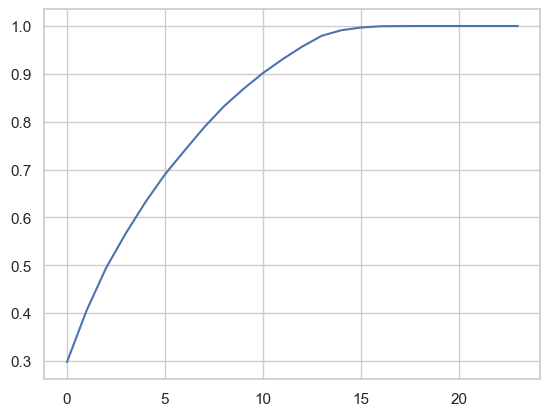

In [204]:
pca = PCA()
_ = pca.fit(agg_scaled)
cumsum = pca.explained_variance_ratio_.cumsum()
plt.plot(cumsum)

In [205]:
pca = PCA(n_components=15)
agg_pca = pca.fit_transform(agg_scaled)

# KMeans Clustering

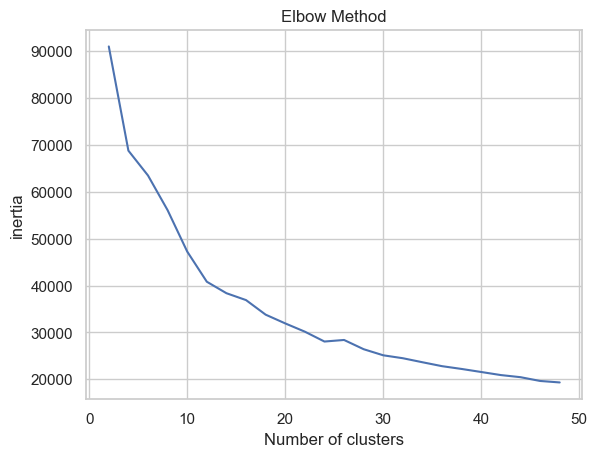

In [206]:
inertia = []
for i in range(2, 50, 2):
    kmeans = KMeans(n_clusters=i, max_iter=500,  random_state=42)
    kmeans.fit(agg_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 50, 2), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.show()

In [207]:
kmeans = KMeans(n_clusters=14, max_iter=500,  random_state=42)
agg['cluster'] = kmeans.fit_predict(agg_scaled)
agg.head()

,Store_id,total_sales,std_sales,avg_sales,total_orders,avg_orders,Discount_Sales_Ratio,Avg_Sales_Growth,average_sales_per_order,sales_ratio_store_type,...,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4,cluster
0,267,26710784.79,15232.585843,51765.086802,41825,81.056202,1.226717,0.036263,638.632033,0.009703,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4
1,82,32487437.37,18733.878582,62960.149942,58482,113.337209,1.170018,0.059160,555.511736,0.011801,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12
2,357,28143722.01,16236.630083,54542.096919,49830,96.569767,1.213290,0.003493,564.794742,0.010223,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13
3,201,28051719.78,14584.098817,54363.798023,53068,102.844961,1.159089,0.042470,528.599529,0.010190,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13
4,295,18989349.27,10058.665397,36801.064477,26870,52.073643,1.078823,0.003124,706.711919,0.005679,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3


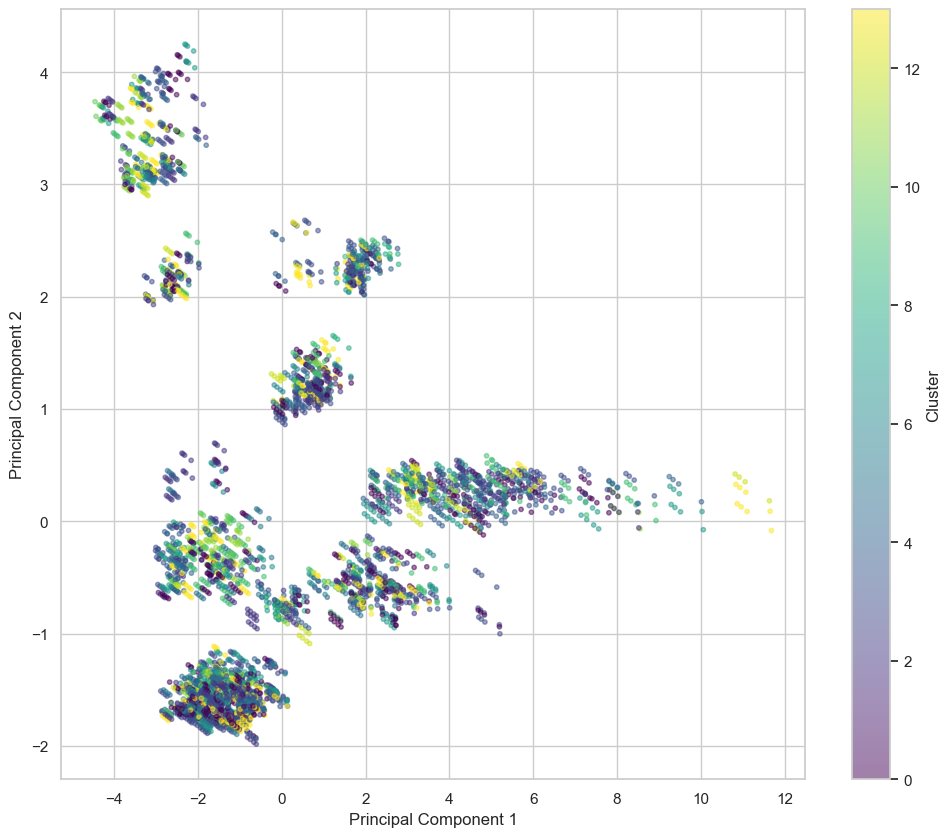

In [208]:
plt.figure(figsize=(12, 10))
scatter=plt.scatter(agg_pca_df.iloc[:, 0], agg_pca_df.iloc[:, 1], c=agg["cluster"], s=10, cmap='viridis', alpha=0.5 )
# add legend
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

# Hierarchical Clustering

In [209]:
Z = fastcluster.linkage(agg_pca, method='ward')

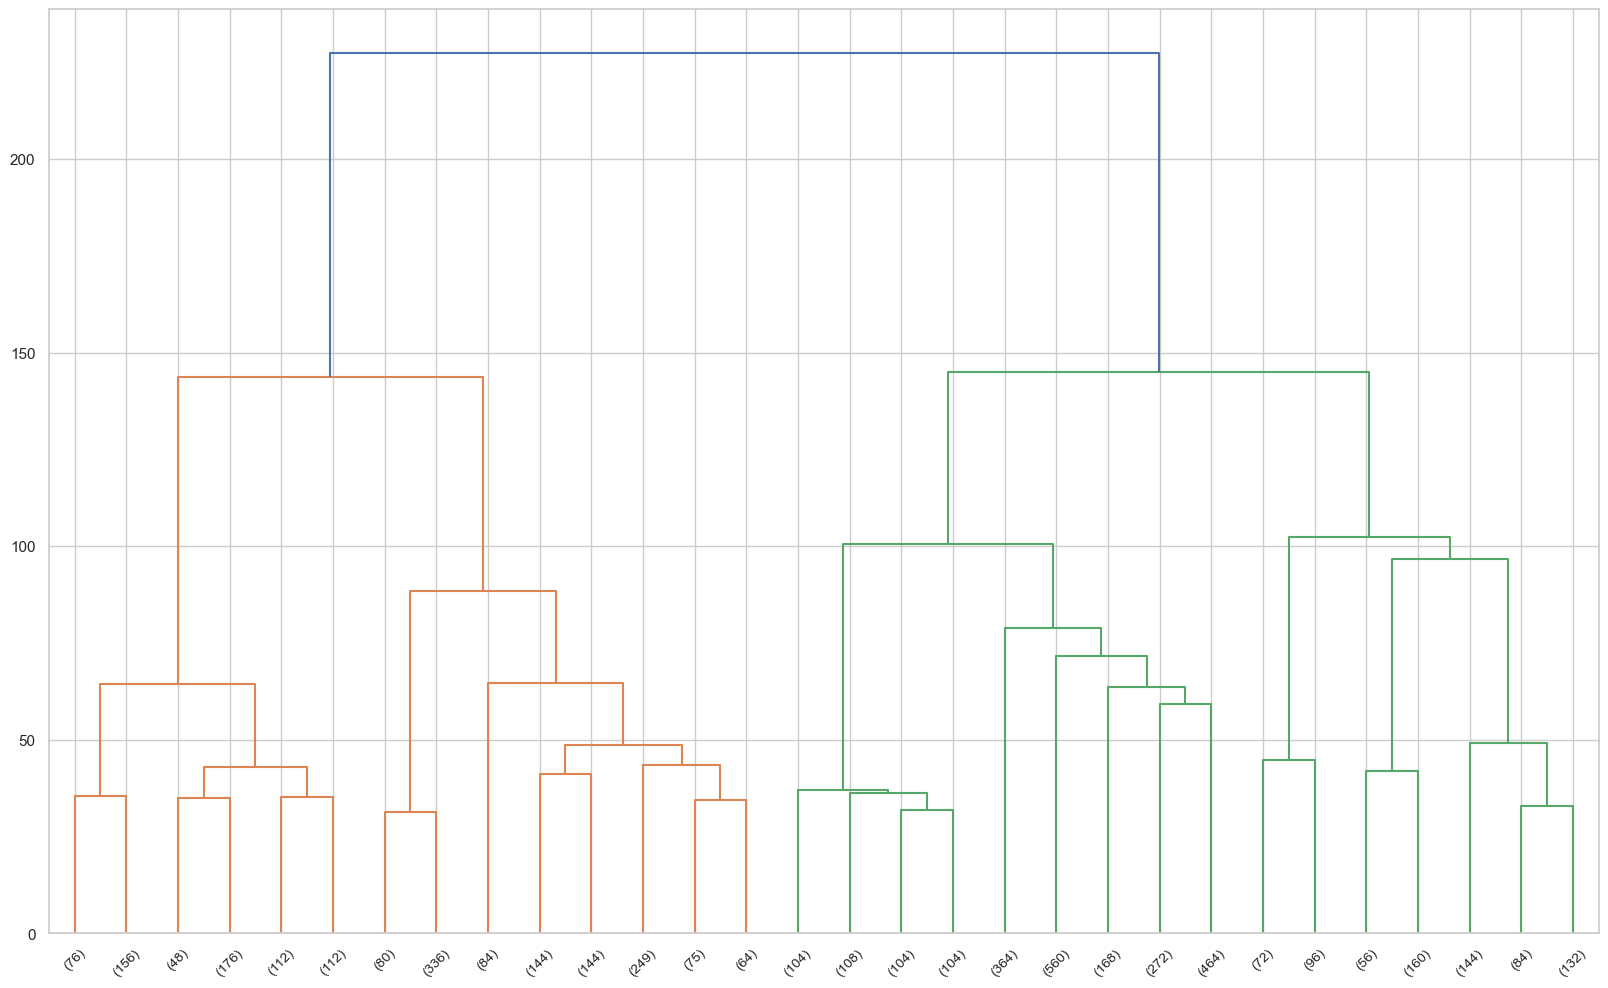

In [210]:
fig, ax = plt.subplots(figsize=(20, 12))
dendrogram( Z, truncate_mode='lastp');

In [211]:
agg["cluster"] = fcluster(Z, 4, criterion='maxclust')

In [212]:
agg_pca_df = pd.DataFrame(agg_pca, columns=[f"pca_{i}" for i in range(agg_pca.shape[1])])

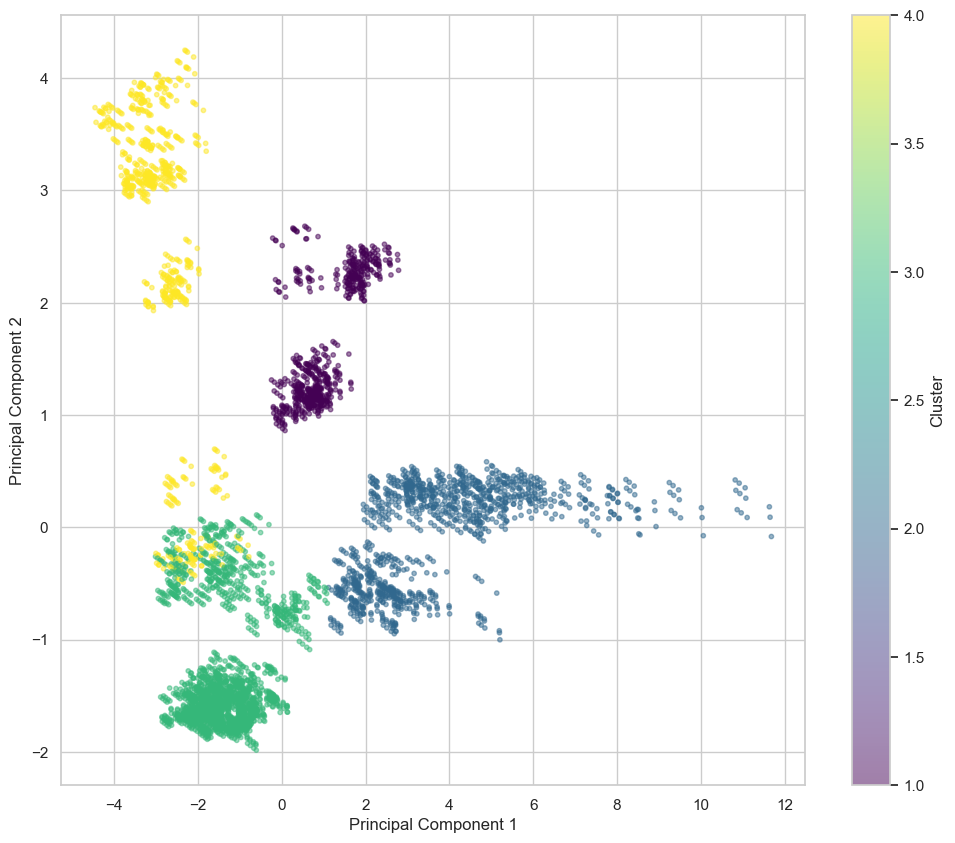

In [213]:
plt.figure(figsize=(12, 10))
scatter=plt.scatter(agg_pca_df.iloc[:, 0], agg_pca_df.iloc[:, 1], c=agg["cluster"], s=10, cmap='viridis', alpha=0.5 )
# add legend
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

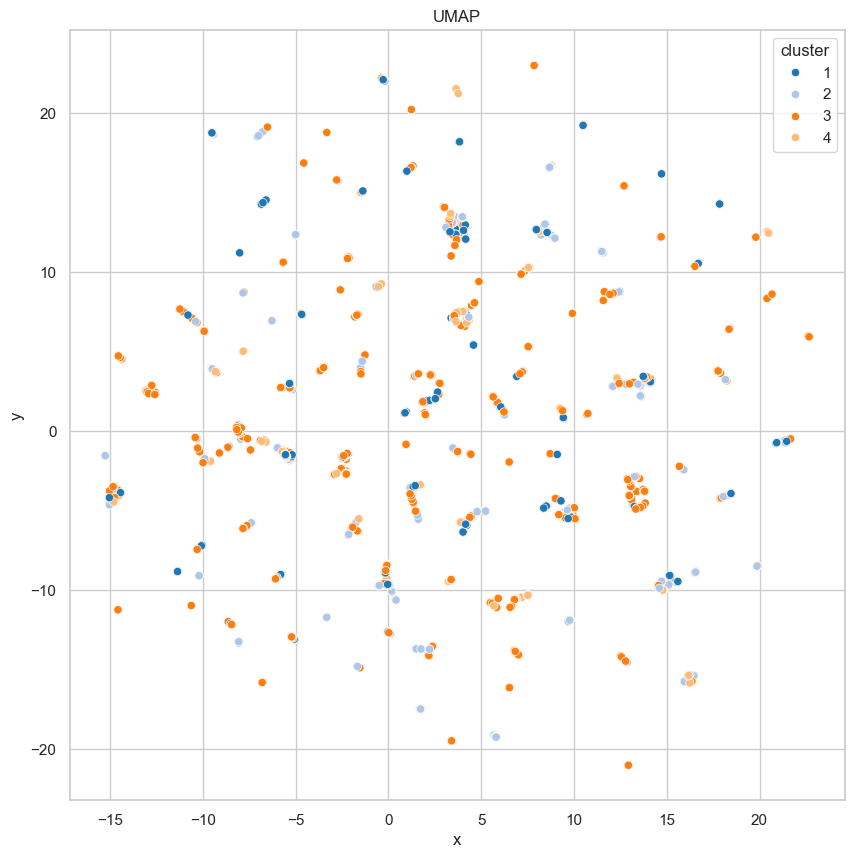

In [214]:
umap_df = pd.DataFrame(agg_umap, columns=['x', 'y'])
umap_df['cluster'] = agg['cluster']
plt.figure(figsize=(10, 10))
sns.scatterplot(data=umap_df, x='x', y='y', hue='cluster', palette='tab20')
plt.title('UMAP')
plt.show()

# Cluster Analysis

In [215]:
agg.columns

Index(['Store_id', 'total_sales', 'std_sales', 'avg_sales', 'total_orders',
       'avg_orders', 'Discount_Sales_Ratio', 'Avg_Sales_Growth',
       'average_sales_per_order', 'sales_ratio_store_type',
       'sales_ratio_store_location', 'sales_ratio_store_region',
       'Store_Type_S1', 'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4',
       'Location_Type_L1', 'Location_Type_L2', 'Location_Type_L3',
       'Location_Type_L4', 'Location_Type_L5', 'Region_Code_R1',
       'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4', 'cluster'],
      dtype='object')

In [216]:
cluster_analysis_df=agg[['total_sales', 'avg_sales', 'total_orders',
       'avg_orders', 'Discount_Sales_Ratio', 'Avg_Sales_Growth',
       'average_sales_per_order', 'sales_ratio_store_type',
       'sales_ratio_store_location', 'sales_ratio_store_region', 'cluster']]
cluster_analysis_df.head()

,total_sales,avg_sales,total_orders,avg_orders,Discount_Sales_Ratio,Avg_Sales_Growth,average_sales_per_order,sales_ratio_store_type,sales_ratio_store_location,sales_ratio_store_region,cluster
0,26710784.79,51765.086802,41825,81.056202,1.226717,0.036263,638.632033,0.009703,0.054919,0.035703,2
1,32487437.37,62960.149942,58482,113.337209,1.170018,0.059160,555.511736,0.011801,0.066797,0.043424,2
2,28143722.01,54542.096919,49830,96.569767,1.213290,0.003493,564.794742,0.010223,0.185647,0.037618,2
3,28051719.78,54363.798023,53068,102.844961,1.159089,0.042470,528.599529,0.010190,0.185040,0.037495,2
4,18989349.27,36801.064477,26870,52.073643,1.078823,0.003124,706.711919,0.005679,0.125261,0.025382,3


In [217]:
cluster_analysis_df = cluster_analysis_df.groupby('cluster').mean()
cluster_analysis_df

,total_sales,avg_sales,total_orders,avg_orders,Discount_Sales_Ratio,Avg_Sales_Growth,average_sales_per_order,sales_ratio_store_type,sales_ratio_store_location,sales_ratio_store_region
cluster,,,,,,,,,,
1,2.408958e+07,46685.230523,37958.929412,73.563817,1.356070,0.022654,634.317667,0.020666,0.059696,0.074868
2,3.051021e+07,59128.306670,52295.248299,101.347380,1.304330,0.023118,586.981606,0.011083,0.062391,0.089662
3,1.994647e+07,38655.948174,30207.295374,58.541270,1.333012,0.016105,662.083009,0.005965,0.060532,0.064170
4,1.485121e+07,28781.411887,22539.994624,43.682160,1.346509,0.013441,665.017185,0.015612,0.082239,0.047919


In [218]:
def create_polar_plot(data, features, cluster_label):
    num_vars = len(features)

    # Compute angle of each axis (in radians)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is made in a circular (polar) form, so we need to "close the loop"
    data = np.concatenate((data, [data[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    ax.fill(angles, data, color='blue', alpha=0.25)
    ax.plot(angles, data, color='blue', linewidth=2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)

    plt.title(f'Cluster {cluster_label}', size=20, color='blue', y=1.1)

    plt.show();

def create_combined_polar_plot(normalized_means, features, cluster_labels):
    num_vars = len(features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

    for i, data in enumerate(normalized_means):
        data = np.concatenate((data, [data[0]]))
        ax.fill(angles, data, alpha=0.25, label=f'Cluster {cluster_labels[i]}')
        ax.plot(angles, data, linewidth=2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)

    plt.title('Cluster Comparison', size=20, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()



In [219]:
scaler = MinMaxScaler()
normalized_means = scaler.fit_transform(cluster_analysis_df)

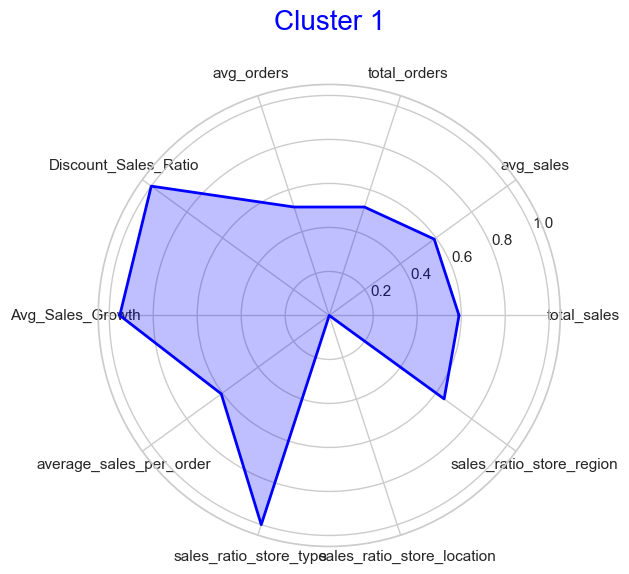

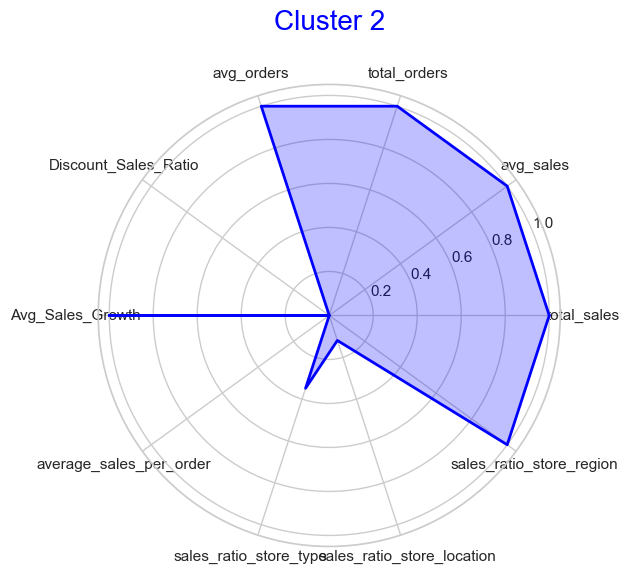

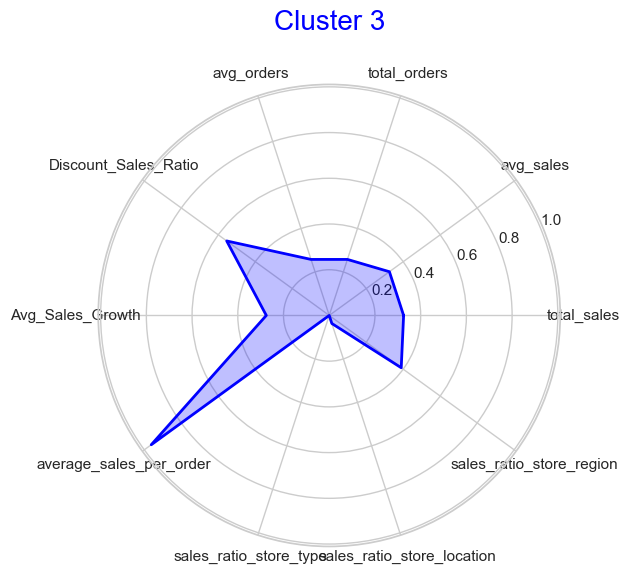

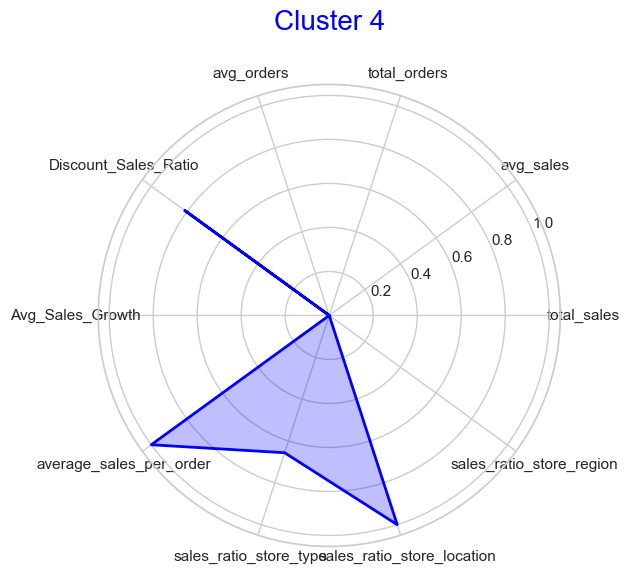

In [220]:
for i in range(len(normalized_means)):
    create_polar_plot(normalized_means[i], cluster_analysis_df.columns, i+1)

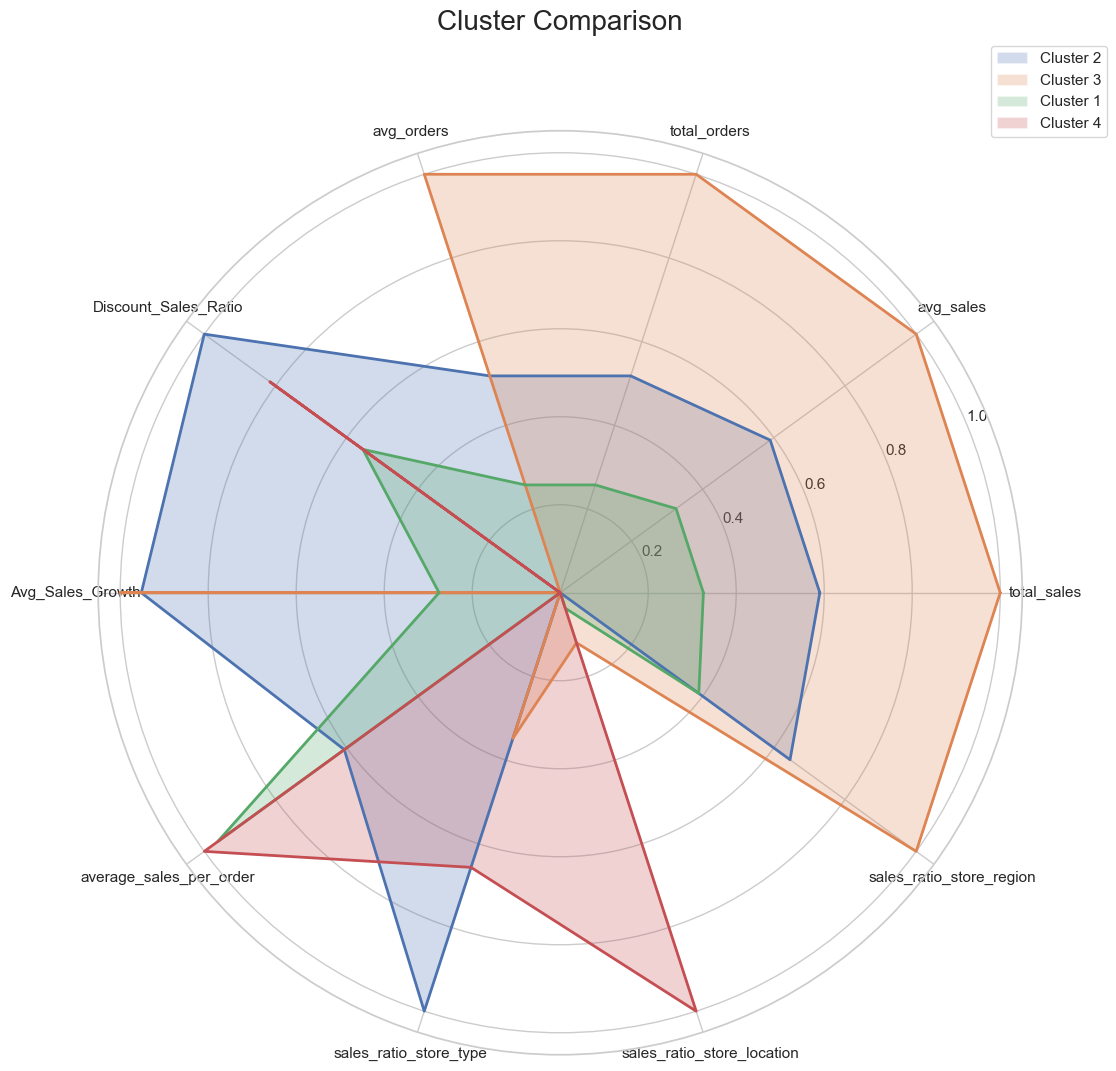

In [221]:
cluster_labels = agg["cluster"].unique().tolist()

create_combined_polar_plot(normalized_means, cluster_analysis_df.columns, cluster_labels)

In [222]:
orig

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,Day_of_Week_Name,Day,Day_of_Week,Month_Name,Month,Year,Quarter,Week,Week_of_Month,Is_Weekend
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,9,7011.84,Monday,1,0,January,1,2018,1,1,1,0
1,T1000002,253,S4,L2,R1,2018-01-01,1,1,60,51789.12,Monday,1,0,January,1,2018,1,1,1,0
2,T1000003,252,S3,L2,R1,2018-01-01,1,1,42,36868.20,Monday,1,0,January,1,2018,1,1,1,0
3,T1000004,251,S2,L3,R1,2018-01-01,1,1,23,19715.16,Monday,1,0,January,1,2018,1,1,1,0
4,T1000005,250,S2,L3,R4,2018-01-01,1,1,62,45614.52,Monday,1,0,January,1,2018,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,1,51,37272.00,Friday,31,4,May,5,2019,2,22,5,0
188336,T1188337,153,S4,L2,R1,2019-05-31,1,0,90,54572.64,Friday,31,4,May,5,2019,2,22,5,0
188337,T1188338,154,S1,L3,R2,2019-05-31,1,0,56,31624.56,Friday,31,4,May,5,2019,2,22,5,0
188338,T1188339,155,S3,L1,R2,2019-05-31,1,1,70,49162.41,Friday,31,4,May,5,2019,2,22,5,0


In [225]:
agg[['Store_id', 'cluster']].drop_duplicates()

,Store_id,cluster
0,267,2
1,82,2
2,357,2
3,201,2
4,295,3
...,...,...
360,257,3
361,269,4
362,358,1
363,26,3


In [227]:
orig=orig.merge(agg[['Store_id', 'cluster']].drop_duplicates(), on='Store_id', how='left')

In [ ]:
orig[["Store_id", "cluster"]].drop_duplicates().to_csv("../../data/processed/store_cluster.csv", index=False)

In [228]:
orig.to_parquet("../../data/processed/train_enhanced.parquet")